In [1]:
import numpy as np
from scipy.stats import gennorm, norm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

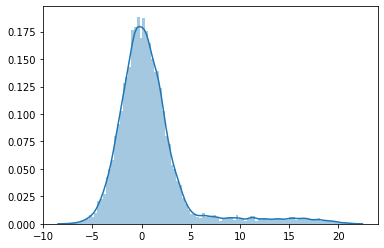

In [19]:
# Generate signal data
N_signal = 1000
signal_data = 10*(1+gennorm(beta=8).rvs(N_signal))

# Generate background data
N_background = 10000
background_data = 2*norm().rvs(N_background)

# Gather into all N and shuffle
data = np.concatenate([signal_data, background_data])
np.random.shuffle(data)

sns.distplot(data, bins=100)

# Algorith description

1. Specify a minimal number of data points per bin
2. Specify a minimal bin lenfth
3. Go from one end to the other, marking edge positions along the way according to the above criteria.
4. Start at the larger value end, since that's the most sensitive. 
5. Store result as dataframe

In [20]:
min_ct_per_bin = 100
print(f'min_ct_per_bin:{min_ct_per_bin}')

min_bin_length = 1 #np.std(data)/5
print(f'min_bin_length:{min_bin_length}')

eps = min_bin_length

min_ct_per_bin:100
min_bin_length:1


In [21]:
# sort data
sorted_data = np.sort(data)[::-1]

# create list to hold edges
n = -1
edge = sorted_data[0]+min_bin_length
edges = []
cts = []
N = len(sorted_data)
indices = np.arange(N).astype(int)

while n < N-1:

    n_new_a = min(n + min_ct_per_bin, N-1)
    ix = (sorted_data <= edge - min_bin_length)
    n_new_b = min(indices[ix]) if sum(ix)>0 else N-1
        
    n_new = max(n_new_a, n_new_b)
    
    assert n_new > n, f'n:{n}, n_new:{n_new}, n_new_a:{n_new_a}, n_new_b:{n_new_b}'
    
    ct_new = n_new-n
    edge_new = sorted_data[n_new]
    n = n_new
    
    # Only record if conditions are satisified
    if ct_new >= min_ct_per_bin and edge_new <= edge-min_bin_length:
        #cts.append(ct_new)
        edges.append(edge_new)
        edge = edge_new
    
# Remove last edge if too few points in the tail
ct_tail = sum(data < edges[-1])
if ct_tail < min_ct_per_bin:
    edges = edges[:-1]
    
# Add bounds to edges
edges.append(sorted_data[-1]-min_bin_length)

# Now sort edges the right way
edges = np.sort(edges)
   
# Report number of bins
num_bins = len(edges)-1
lengths = edges[1:]-edges[:-1]
print(f'num_bins: {num_bins}')
print(f'lengths: {lengths}')
    
# Now compute counts
cts = np.zeros(num_bins)
for i in range(num_bins):
    cts[i] = sum((sorted_data >= edges[i]) & (sorted_data < edges[i+1]))
    
print(edges)   
print(cts)

num_bins: 18
lengths: [3.68124554 1.02883417 1.00346165 1.00031382 1.00001426 1.00000609
 1.00037378 1.00118275 1.0007018  1.00119853 1.00180136 1.19848883
 1.32107538 1.85306617 1.74034821 2.03728381 1.95958833 1.98850198]
[-8.38920766 -4.70796212 -3.67912795 -2.6756663  -1.67535248 -0.67533822
  0.32466787  1.32504165  2.3262244   3.3269262   4.32812473  5.32992609
  6.52841492  7.8494903   9.70255647 11.44290468 13.48018848 15.43977682
 17.4282788 ]
[ 102.  228.  579. 1130. 1666. 2011. 1768. 1407.  758.  407.  144.  100.
  100.  100.  100.  100.  100.  100.]


In [22]:
# Create a dataframe to hold results
bin_df = pd.DataFrame()
bin_df['count'] = cts
bin_df['left_in'] = edges[:-1]
bin_df['right_ex'] = edges[1:]
bin_df['length'] = bin_df['right_ex'] - bin_df['left_in'] 
bin_df

,count,left_in,right_ex,length
0,102.0,-8.389208,-4.707962,3.681246
1,228.0,-4.707962,-3.679128,1.028834
2,579.0,-3.679128,-2.675666,1.003462
3,1130.0,-2.675666,-1.675352,1.000314
4,1666.0,-1.675352,-0.675338,1.000014
5,2011.0,-0.675338,0.324668,1.000006
6,1768.0,0.324668,1.325042,1.000374
7,1407.0,1.325042,2.326224,1.001183
8,758.0,2.326224,3.326926,1.000702
9,407.0,3.326926,4.328125,1.001199


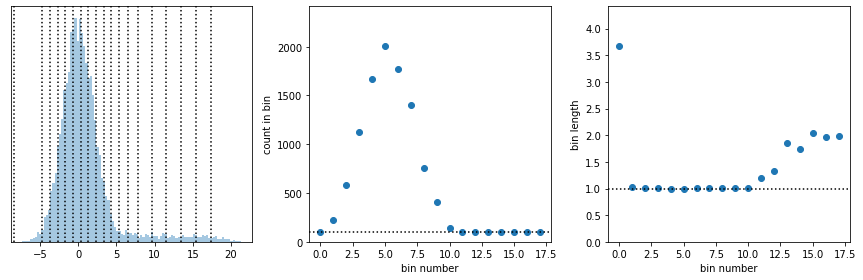

In [26]:
fig, axs = plt.subplots(1,3, figsize=[12,4])

ax = axs[0]
sns.distplot(data, bins=100, ax=ax, kde=False)
for edge in edges:
    ax.axvline(edge, linestyle=':', color='k')
ax.set_yticks([])
    
ax = axs[1]
x = bin_df.index
y = bin_df['count']
ax.plot(x,y,'o')
ax.set_ylim([0, max(y)*1.2])
ax.axhline(min_ct_per_bin, color='k', linestyle=':')
ax.set_ylabel('count in bin')
ax.set_xlabel('bin number')

ax = axs[2]
x = bin_df.index
y = bin_df['length']
ax.plot(x,y,'o')
ax.set_ylim([0, max(y)*1.2])
ax.axhline(min_bin_length, color='k', linestyle=':')
ax.set_ylabel('bin length')
ax.set_xlabel('bin number')

fig.tight_layout()
fig.savefig('adaptive_binning.pdf')

----------------

### Algorithm that David and I sketched. It actually doesn't produce very evenly distributed bins

In [7]:
# data_df = pd.DataFrame(data)
# num_bins_start = 1000
# x = pd.qcut(data, num_bins_start)
# intervals = x.value_counts().index
# counts = x.value_counts().values
# df = pd.DataFrame()
# df['left'] = [i.left for i in intervals]
# df['right'] = [i.right for i in intervals]
# df['count'] = counts
# df['length'] = [i.length for i in intervals]
# df

In [8]:
# num_bins_final = 20

# tmp_df = df.copy()
# while len(tmp_df) > num_bins_final:

#     # Compute smallest bin
#     i = tmp_df['length'].idxmin()
#     l = tmp_df.loc[i,'length'] 

#     #print(f'num_rows: {len(df)}, min lenfth: {l}')
    
#     # Figure out whether bin above or below is smaller
#     l_left = tmp_df.loc[i-1,'length'] if i >= 1 else np.inf
#     l_right = tmp_df.loc[i+1,'length'] if i <= len(df)-2 else np.inf 

#     # Make sure that one of them is finite
#     assert np.isfinite(l_left) or np.isfinite(l_right)

#     if l_left <= l_right:
#         # Absorb into interval on the left
#         tmp_df.loc[i-1,'right'] = tmp_df.loc[i,'right']
#         tmp_df.loc[i-1,'length'] += tmp_df.loc[i,'length']
#         tmp_df.loc[i-1,'count'] += tmp_df.loc[i,'count']
#     else:
#         # Absorb into interval on the right
#         tmp_df.loc[i+1,'left'] = tmp_df.loc[i,'left']
#         tmp_df.loc[i+1,'length'] += tmp_df.loc[i,'length']
#         tmp_df.loc[i+1,'count'] += tmp_df.loc[i,'count']

#     # Remove row and recompute indices
#     tmp_df.drop([i], inplace=True)
#     tmp_df.reset_index(inplace=True, drop=True)
    
# # Verify that left and right borders match
# lefts = tmp_df['left'].values
# rights = tmp_df['right'].values

# assert np.all(np.isclose(lefts[1:],rights[:-1])), 'Edge boundaries dont match up!'
    
# tmp_df

In [9]:
# fig, ax = plt.subplots()

# sns.distplot(data, bins=30, ax=ax)
# edges = tmp_df['left'].values[1:]
# for edge in edges:
#     ax.axvline(edge, linestyle=':', color='k')